# Import and boiler plate code

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random 
import torch
from torch import autograd
import torch.nn.functional as F
import time
import math
from skimage import io,transform as sk_transform


Importing and Preparing Data

In [136]:
images=np.load('data/images.npy')
labels=np.load('data/labels.npy')
label_ids,count=np.unique(labels,return_counts=True)
print(label_ids,count)


(array([0, 1, 2, 3, 4], dtype=uint8), array([10000, 10000, 10000, 10000, 10000]))


In [137]:
shape_images_flat=(images.shape[0],images.shape[1]*images.shape[2])
images_normal=np.ndarray(shape=shape_images_flat)

# normalizing and flattening images
for index in range(len(images)):
    images_normal[index]=((images[index]-images[index].mean())/images[index].std()).flat

#  braking data set into train,validation and test sets
train_images=images_normal[0:45000]
train_labels=labels[0:45000]

validation_images=images_normal[45000:50000]
validation_labels=labels[45000:50000]

test_images=images_normal[45000:50000]
test_labels=labels[45000:50000]



In [4]:
def accuracy(y, y_hat):
    a=(y==y_hat)
    return a.astype(np.float).mean()

In [5]:
def approx_accuracy(curr_images,curr_labels,length=-1):
    if length==-1:
        length=len(curr_images)
        
    shuffle_list=np.random.choice(len(curr_images), length)
    shuffled_images=curr_images[shuffle_list]
    shuffled_labels=curr_labels[shuffle_list]
    
    x = autograd.Variable(torch.from_numpy(shuffled_images.astype(np.float32))).cuda()
    y = autograd.Variable(torch.from_numpy(shuffled_labels.astype(np.int))).cuda()
    _,y_hat =torch.max(model(x),1)
    # print(y_hat.size())
    return accuracy(y.cpu().data.numpy(), y_hat.cpu().data.numpy())
         

In [7]:
def train(batch_size):
    # model.train() puts our model in train mode, which can require different
    # behavior than eval mode (for example in the case of dropout).
    model.train()
    
    # i is is a 1-D array with shape [batch_size]
    i = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    x = autograd.Variable(torch.from_numpy(random_augment_image(train_images[i]).astype(np.float32))).cuda()
    y = autograd.Variable(torch.from_numpy(train_labels[i].astype(np.int))).cuda()
    
    optimizer.zero_grad()
    y_hat_ = model(x)
    loss = F.cross_entropy(y_hat_, y).cuda()
    loss.backward()
    
    optimizer.step()
    return loss.data[0]


# Data Augmentation Code

In [6]:
def random_augment_image(images):
    
    for i in xrange(0,images.shape[0]):
        image=images[i]
        image=image.reshape(26,26)
        # print(image.shape)
        ## mirror flipping
        flip_probab = random.random()
        if flip_probab <=0.8:
            image = np.fliplr(image)

        # rotate image parmaeter:
        angle = math.radians(random.randrange(-30, +30))
        
        # translate image parameter
        tr_distance_x = random.randrange(-3, +3)
        tr_distance_y = random.randrange(-3, +3)
        # scaling image parameter
        scaling_val=random.uniform(0.7,1.3) 
        
        tform=sk_transform.SimilarityTransform(scale=scaling_val, rotation=angle,\
                                                    translation=(tr_distance_x, tr_distance_y))
        # transform probabilty 
        tr_probab= random.random()
        if tr_probab<=0.8:
            image = sk_transform.warp(image,inverse_map=tform)        
        images[i]=image.flat
    return images

##  BEST MODEL - With Best accuracy

In [8]:
batch_size=60
learning_rate=1e-3
NUM_OPT_STEPS=30000

HEIGHT,WIDTH=26,26
NUM_CLASSES=5
NUM_HIDDEN_UNITS_1=500
NUM_HIDDEN_UNITS_2=100
# NUM_OPT_STEPS=train_labels.shape[0]/batch_size

In [9]:
#Best Model 
class Best_Model(torch.nn.Module):
    def __init__(self):
        super(Best_Model,self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3,stride=1)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1)
        self.fc1 = torch.nn.Linear( 3200, NUM_HIDDEN_UNITS_1)
        self.fc2 = torch.nn.Linear(NUM_HIDDEN_UNITS_1, NUM_HIDDEN_UNITS_2)
        self.fc3 = torch.nn.Linear(NUM_HIDDEN_UNITS_2, NUM_CLASSES)
        self.F_max_pool2d = F.max_pool2d
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
      
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x= self.F_max_pool2d(x,3)
        x = F.relu(self.conv3(x))
        n, c, h, w = x.size()
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    

In [10]:
model=Best_Model().cuda()
print(model)
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)


Best_Model (
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear (3200 -> 500)
  (fc2): Linear (500 -> 100)
  (fc3): Linear (100 -> 5)
)


In [11]:
train_accs, val_accs,test_accs = [], [] ,[]
start=time.time()

for i in range(NUM_OPT_STEPS):
    train(batch_size)    
    if i % 100 == 0:
        train_accs.append(approx_accuracy(train_images,train_labels,1000))
        val_accs.append(approx_accuracy(validation_images,validation_labels))
        test_accs.append(approx_accuracy(test_images,test_labels))
    if i%1000 == 0:
        print("%6d %5.3f %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1],test_accs[-1]))

end=time.time()
print('Time taken', end-start)

     0 0.290 0.298 0.305
  1000 0.916 0.916 0.927
  2000 0.944 0.948 0.944
  3000 0.953 0.943 0.941
  4000 0.940 0.942 0.943
  5000 0.955 0.944 0.947
  6000 0.967 0.948 0.948
  7000 0.954 0.947 0.949
  8000 0.965 0.959 0.952
  9000 0.963 0.951 0.949
 10000 0.962 0.957 0.958
 11000 0.974 0.951 0.954
 12000 0.969 0.958 0.961
 13000 0.968 0.952 0.954
 14000 0.972 0.957 0.957
 15000 0.974 0.959 0.961
 16000 0.975 0.957 0.962
 17000 0.977 0.960 0.959
 18000 0.983 0.960 0.957
 19000 0.976 0.958 0.956
 20000 0.976 0.948 0.957
 21000 0.983 0.960 0.959
 22000 0.980 0.962 0.961
 23000 0.985 0.956 0.951
 24000 0.983 0.958 0.958
 25000 0.979 0.950 0.945
 26000 0.977 0.955 0.952
 27000 0.981 0.958 0.956
 28000 0.981 0.956 0.956
 29000 0.989 0.962 0.957
('Time taken', 604.4101758003235)


 29999 0.987 0.960


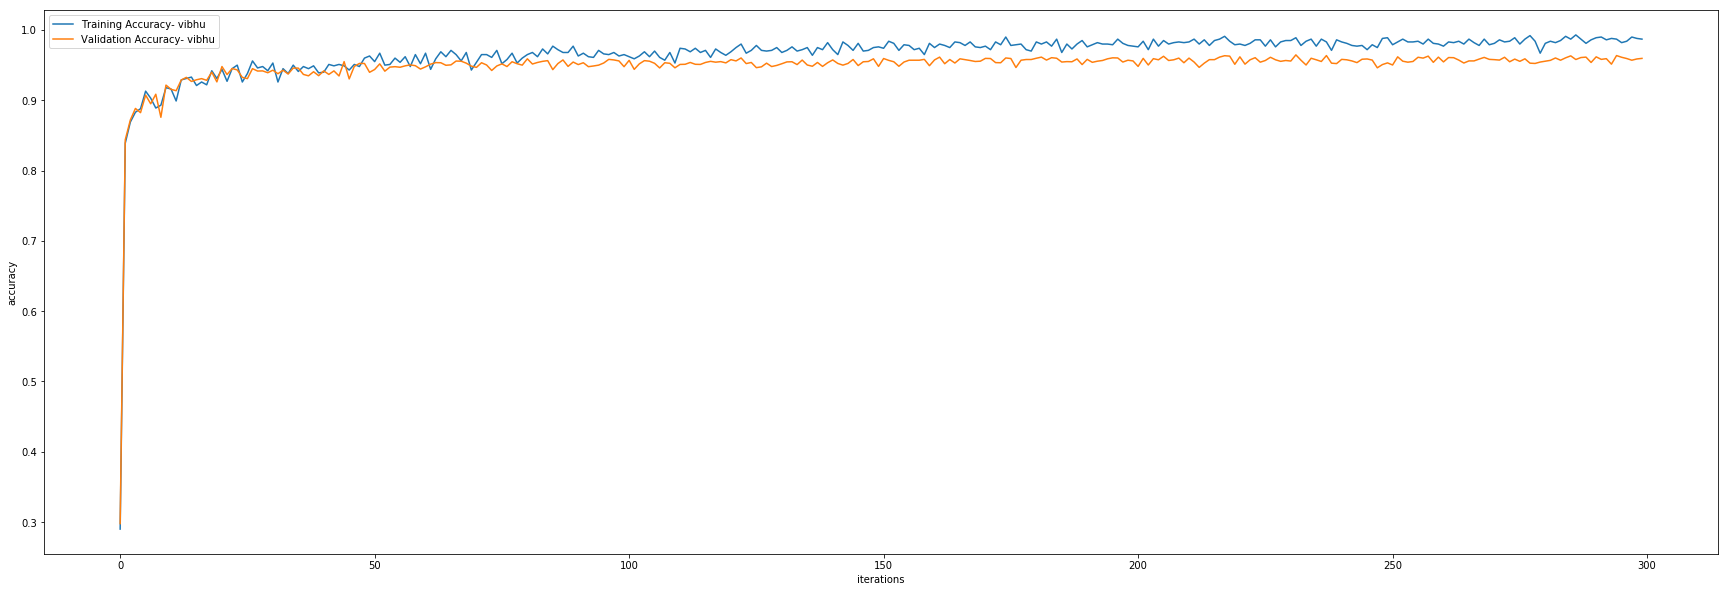

In [13]:
print("%6d %5.3f %5.3f" % ( i, train_accs[-1], val_accs[-1]))
plt.figure(figsize=(30, 10))
plt.xlabel('iterations')
plt.ylabel('accuracy')
training_accuracy_line,=plt.plot(train_accs,label='Training Accuracy- vibhu ')
validation_accuracy_line,=plt.plot(val_accs,label='Validation Accuracy- vibhu')
plt.legend(handles=[training_accuracy_line, validation_accuracy_line])

# Failure Mode Code

Function to detect correct vs incorrect

In [157]:
##
correct_pred_images=[]
incorrect_pred_images=[]
correct_pred_labels=[]
incorrect_pred_labels=[]
incorrect_actual_labels=[]

x = autograd.Variable(torch.from_numpy(validation_images.astype(np.float32))).cuda()
_,y_hat =torch.max(model(x),1)

pred=y_hat.cpu().data.numpy()

for i in xrange(0,len(pred)):
    if(pred[i]==validation_labels[i]):
        correct_pred_images.append(i)
        correct_pred_labels.append(validation_labels[i])
    else:
        incorrect_pred_images.append(i)
        incorrect_pred_labels.append(pred[i])
        incorrect_actual_labels.append(validation_labels[i])
        
        

incorrectly classfied images 


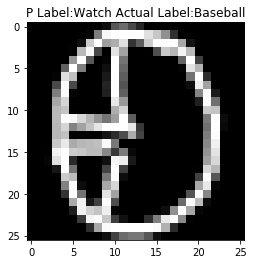

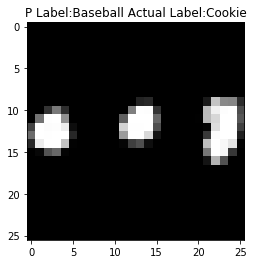

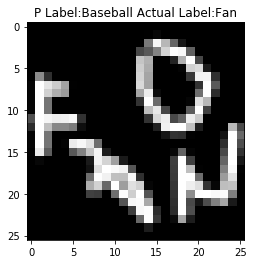

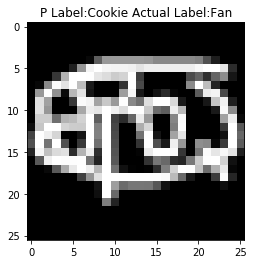

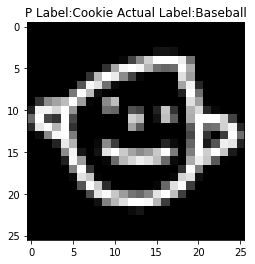

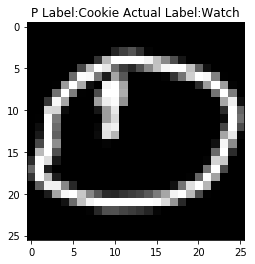

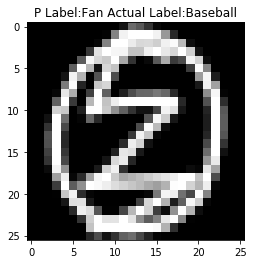

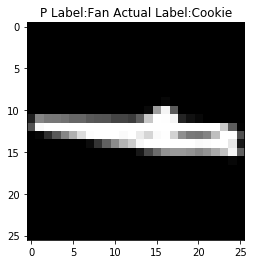

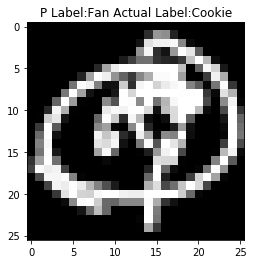

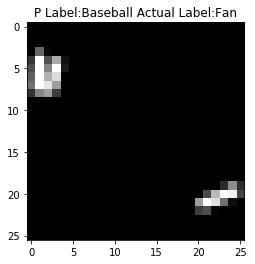

In [158]:
incorrect_images=images[np.asarray(incorrect_images_index_list)+45000]

dictionary = {3: "Watch", 4: "Fan", 0 : "Apple", 1:"Baseball", 2:"Cookie"}

print("incorrectly classfied images ")
for i in xrange(0,10):
    plt.figure()
    plt.title("P Label:"+str(dictionary[incorrect_pred_labels[i]])+" Actual Label:"+str(dictionary[incorrect_actual_labels[i]]))
    plt.imshow(incorrect_images[i],cmap='gray')


Correctly classfied images 


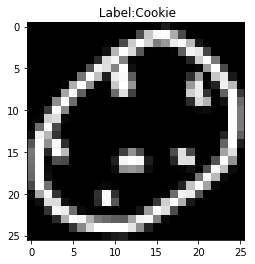

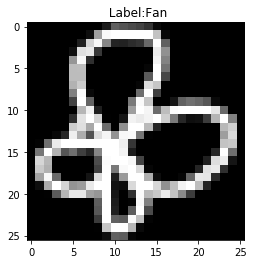

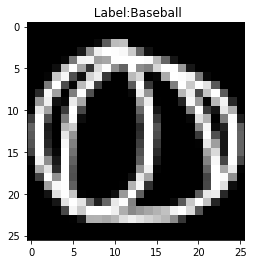

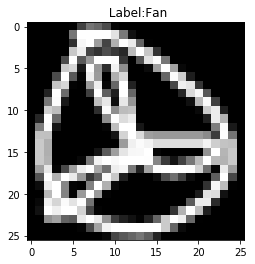

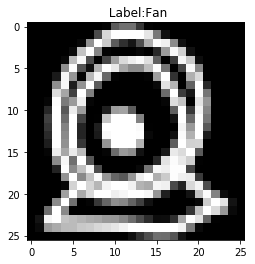

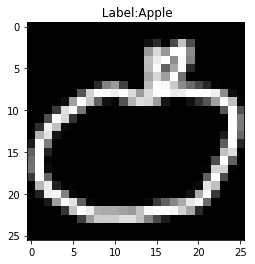

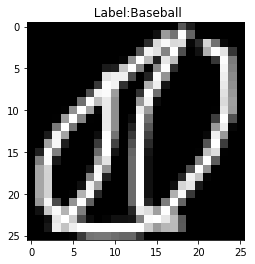

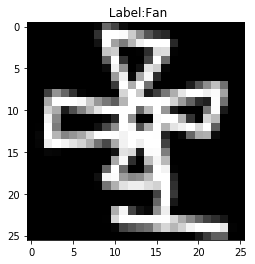

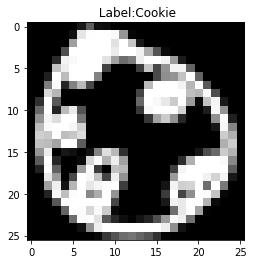

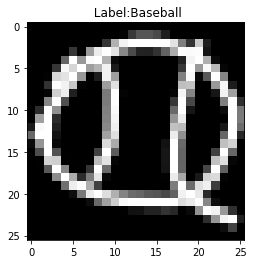

In [159]:
correct_images=images[np.asarray(correct_pred_images)+45000]

dictionary = {3: "Watch", 4: "Fan", 0 : "Apple", 1:"Baseball", 2:"Cookie"}

print("Correctly classfied images ")
for i in xrange(0,10):
    plt.figure()
    plt.title(" Label:"+str(dictionary[correct_pred_labels[i]]))
    plt.imshow(correct_images[i],cmap='gray')


# Qualitative difference b/w images


Yes, We can clearly see that we even as human find it very diffcult to predict these acuuractely.
The incorrect images are not of a good quality for any kind of classification task.


# Gassuain Noise Test

In [167]:
def add_gaussian_noise(images):
    for i in xrange(0,images.shape[0]):
        image=images[i].flat
        # normalizing and flattening images
        image=np.asarray(image)
        sigma=(image.max()-image.min())/10
        s = np.random.normal(image.mean(), sigma, len(image))
        image = image + s
        images[i]=image.reshape(26,26)
    return images

Noisy  images 


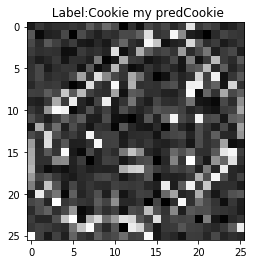

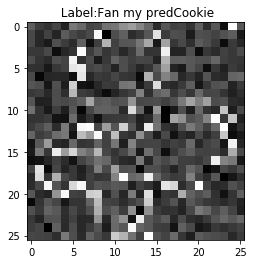

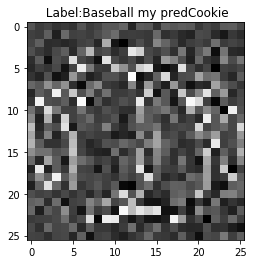

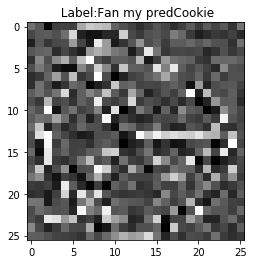

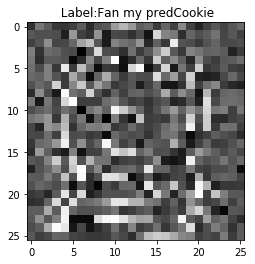

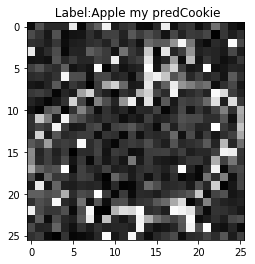

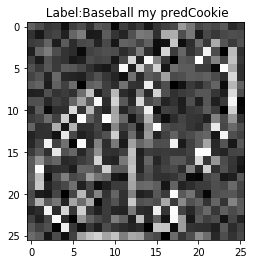

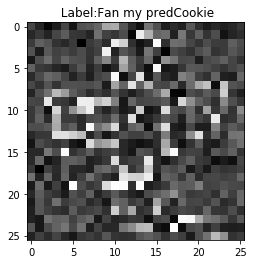

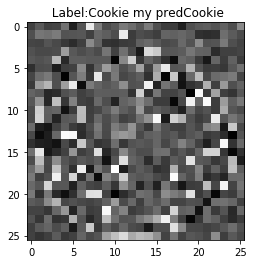

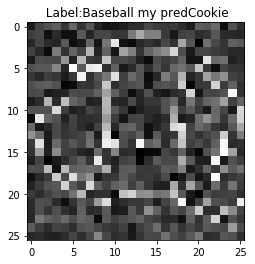

In [168]:
correct_images=images[np.asarray(correct_pred_images)+45000]

correct_image_noise=add_gaussian_noise(correct_images)
shape_images_flat=(correct_image_noise.shape[0],correct_image_noise.shape[1]*correct_image_noise.shape[2])
noisy_images_normal=np.ndarray(shape=shape_images_flat)

for index in range(len(correct_image_noise)):
    noisy_images_normal[index]=((correct_image_noise[index]-correct_image_noise[index].mean())/correct_image_noise[index].std()).flat

dictionary = {3: "Watch", 4: "Fan", 0 : "Apple", 1:"Baseball", 2:"Cookie"}
x_noise = autograd.Variable(torch.from_numpy(noisy_images_normal.astype(np.float32))).cuda()
model.eval()
_,y_hat =torch.max(model(x_noise),1)

pred=y_hat.cpu().data.numpy()

print("Noisy  images ")
for i in xrange(0,10):
    plt.figure()
    plt.title(" Label:"+str(dictionary[correct_pred_labels[i]]+" my pred" +str(dictionary[pred[i]] )))
    plt.imshow(correct_image_noise[i],cmap='gray')


No. these images are too noisy all it predicts is cookie. Human classification is difficult too.


# Flip  Test

In [179]:
def flip(images):
    for i in xrange(0,images.shape[0]):
        image=images[i]
        image = np.fliplr(image)
        images[i]=image
    return images

Flipped  images 


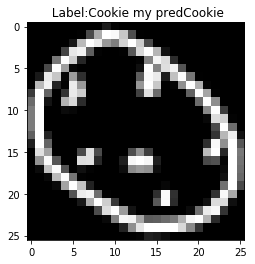

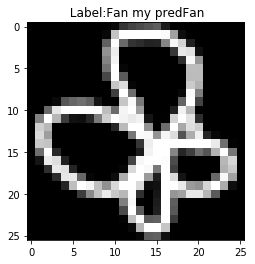

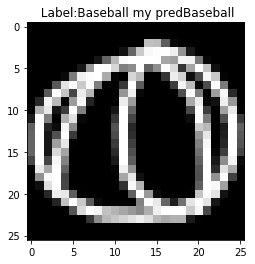

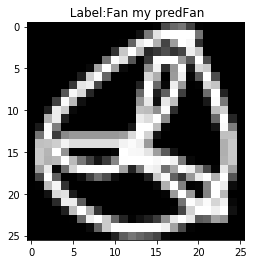

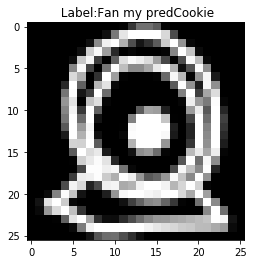

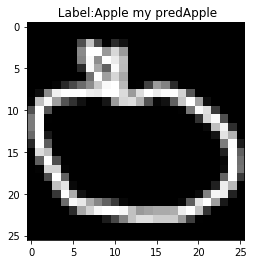

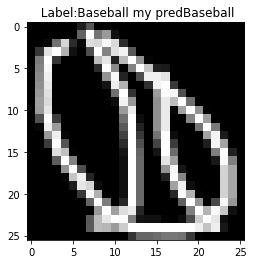

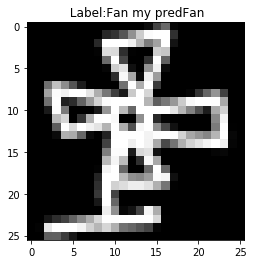

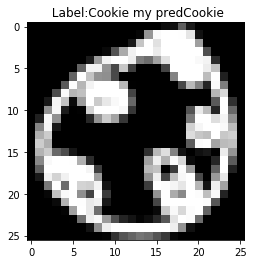

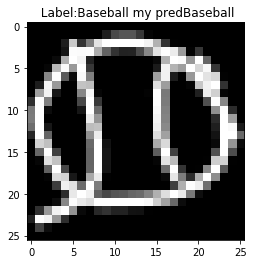

In [180]:
correct_images=images[np.asarray(correct_pred_images)+45000]

correct_image_flip=flip(correct_images)
shape_images_flat=(correct_image_flip.shape[0],correct_image_flip.shape[1]*correct_image_flip.shape[2])
flip_images_normal=np.ndarray(shape=shape_images_flat)

for index in range(len(correct_image_flip)):
    flip_images_normal[index]=((correct_image_flip[index]-correct_image_flip[index].mean())/correct_image_flip[index].std()).flat

dictionary = {3: "Watch", 4: "Fan", 0 : "Apple", 1:"Baseball", 2:"Cookie"}
x = autograd.Variable(torch.from_numpy(flip_images_normal.astype(np.float32))).cuda()
model.eval()

_,y_hat =torch.max(model(x),1)

pred=y_hat.cpu().data.numpy()

print("Flipped  images ")
for i in xrange(0,10):
    plt.figure()
    plt.title(" Label:"+str(dictionary[correct_pred_labels[i]]+" my pred" +str(dictionary[pred[i]] )))
    plt.imshow(correct_image_flip[i],cmap='gray')



It is immune to noise because i trained it with data augmentation, it still has 100 % accuracy

*** Create a new Markdown cell and answer: Let's assume that your model \failed"
to classify the flipped images correctly. 
First of all, is this \failure" necessarily a
failure? In other words, do scenarios exist in which you do not want to remain
invariant to horizontal 
ipping? Now, suppose that in this application you do want
to remain invariant to horizontal 
ipping. How could you change your training
process so that the model remains robust to such transformations?

In, the case where, the left flioped image and the right fir image belong to a different class.
Example, while detecting left and right hande glove, horizonatl flipping will become useless.

Adding augmanetation . with probabilty is the way to go about it.

I have done these changes in the random_augment_image code.

I have added:

    Mirror flipping
    
    Rotated image (-30 to 30)
    
    Traslation(-3 to 3) along both axis
    
    Sacaled-(0.7,1.3) 